44Prepare the data
Check the data and its stationarity

In [34]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import r2_score

In [35]:
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
stock_data = pd.read_excel("C:/Users/ROG/Desktop/so this is the sadness/MINI Project/Data/candlestick_chart_data.xlsx", index_col='Date', parse_dates=['Date'])
pd.set_option('display.max_columns', None)
print(stock_data)

            Opening price  Highest price  Lowest price  Closing price  \
Date                                                                    
2025-01-02            267            303           243            288   
2025-01-03            281            317           270            291   
2025-01-06            278            346           276            327   
2025-01-07            336            388           317            369   
2025-01-08            365            374           303            311   
...                   ...            ...           ...            ...   
2025-06-25             96            114            93            104   
2025-06-26            113            114            94            111   
2025-06-27            106            113            93            111   
2025-06-30            103            113            93            110   
2025-07-01             94            114            93            107   

            Trading volume  Turnover  Median price

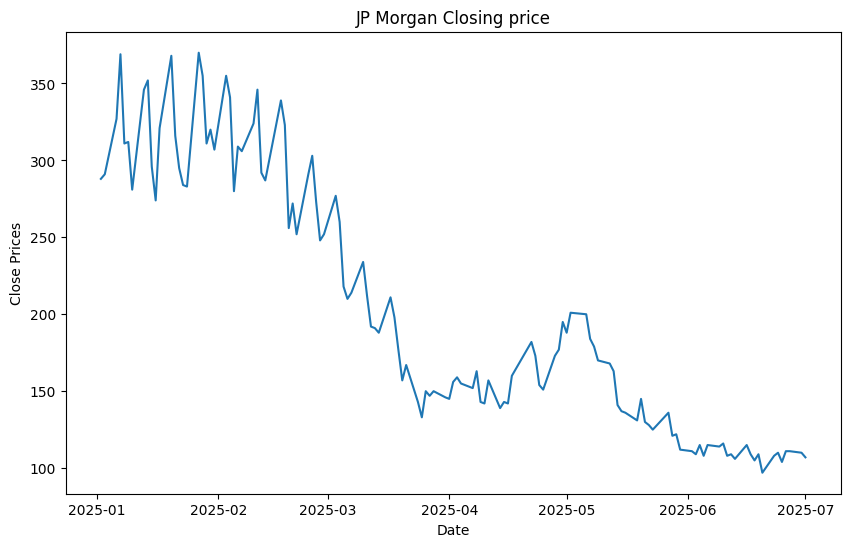

In [36]:
#Visualize the per day closing price of the stock.
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Closing price'])
plt.title('JP Morgan Closing price')
plt.show()


<Axes: ylabel='Density'>

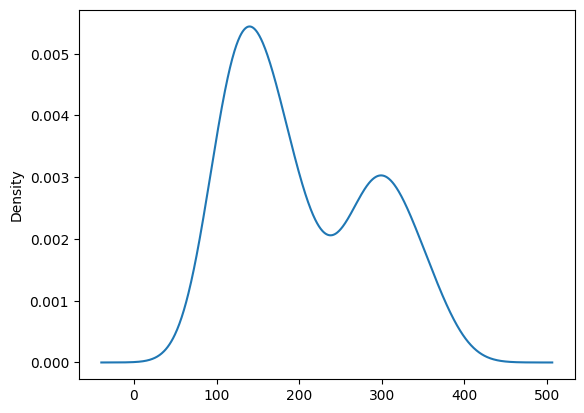

In [37]:
# Distribution of the dataset
df_close=stock_data['Closing price']
df_close.plot(kind='kde')

In [38]:
#Using the ADF test to check if a series is stationary or not because time series analysis only works with stationary data
def test_stationarity(timeseries):
    print("Results for dickey fuller test")
    results=adfuller(timeseries, autolag='AIC')
    output=pd.Series(results[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in results[4].items():
        output['critical value (%s)'%key] =values
    print(output)

In [39]:
test_stationarity(df_close)

Results for dickey fuller test
Test Statistics                 -0.922090
p-value                          0.780611
No. of lags used                10.000000
Number of observations used    114.000000
critical value (1%)             -3.489058
critical value (5%)             -2.887246
critical value (10%)            -2.580481
dtype: float64


Text(0.5, 1.0, '2 order differencing')

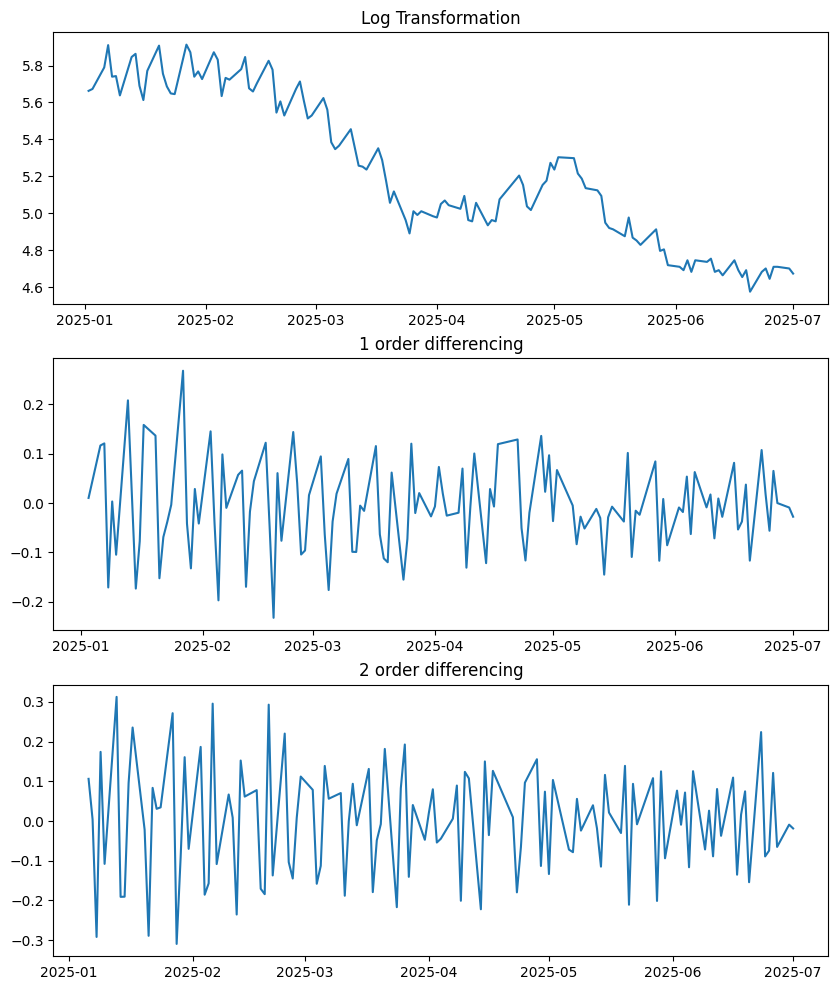

In [40]:
# # Nomalization
# avg, dev=df_close.mean(),df_close.std()
# df_nomal=(df_close-avg)/dev
# df_nomal.plot()
# # Log transformation
df_log=np.log(df_close)
fig,axe = plt.subplots(3,1, figsize=(10,12))
axe[0].plot(df_log)
axe[0].set_title('Log Transformation')
# Take first difference to remove the trend
df_diff=df_log.diff().dropna()
axe[1].plot(df_diff)
axe[1].set_title('1 order differencing')

df_diff_2=df_diff.diff().dropna()
axe[2].plot(df_diff_2)
axe[2].set_title('2 order differencing')

In [41]:
test_stationarity(df_diff)

Results for dickey fuller test
Test Statistics                 -3.701667
p-value                          0.004090
No. of lags used                 5.000000
Number of observations used    118.000000
critical value (1%)             -3.487022
critical value (5%)             -2.886363
critical value (10%)            -2.580009
dtype: float64


In [42]:
test_stationarity(df_diff_2)

Results for dickey fuller test
Test Statistics               -6.966868e+00
p-value                        8.868723e-10
No. of lags used               8.000000e+00
Number of observations used    1.140000e+02
critical value (1%)           -3.489058e+00
critical value (5%)           -2.887246e+00
critical value (10%)          -2.580481e+00
dtype: float64


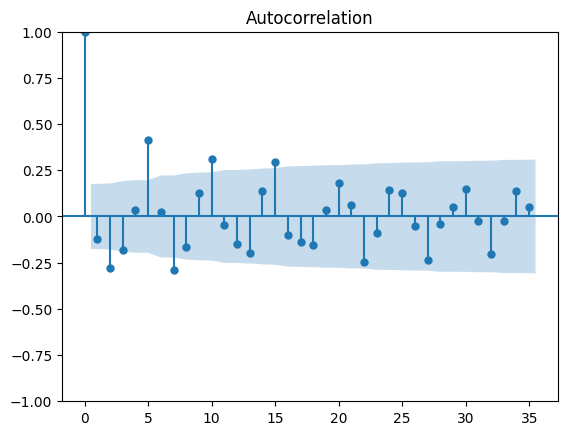

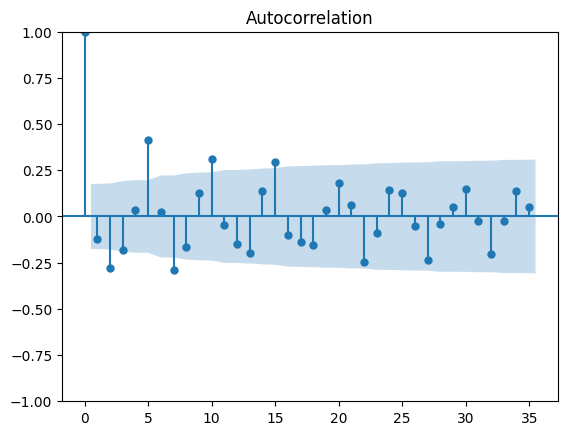

In [43]:
n_lags=35
plot_acf(df_diff,lags=n_lags, alpha=0.05)

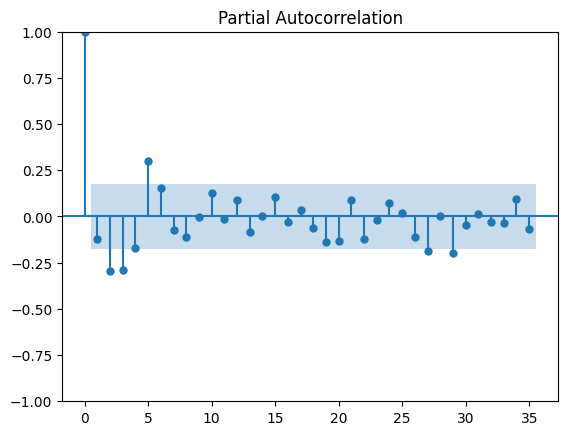

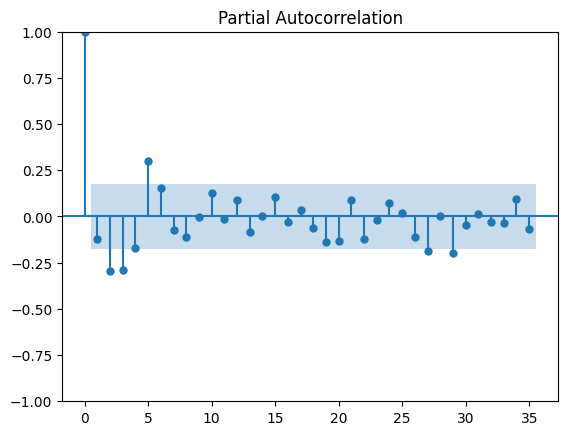

In [44]:
plot_pacf(df_diff,lags=n_lags)

Split data

In [45]:
def train_test_split(df,size=0.9):
    train_data, test_data=df[:int(len(df)*size)], df[int(len(df)*size):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(df,'green', label='Train data')
    plt.plot(test_data, 'blue', label='Test data')
    plt.legend()
    return train_data, test_data

DatetimeIndex(['2025-01-02', '2025-01-03', '2025-01-06', '2025-01-07',
               '2025-01-08', '2025-01-09', '2025-01-10', '2025-01-13',
               '2025-01-14', '2025-01-15',
               ...
               '2025-06-18', '2025-06-19', '2025-06-20', '2025-06-23',
               '2025-06-24', '2025-06-25', '2025-06-26', '2025-06-27',
               '2025-06-30', '2025-07-01'],
              dtype='datetime64[ns]', name='Date', length=125, freq=None)


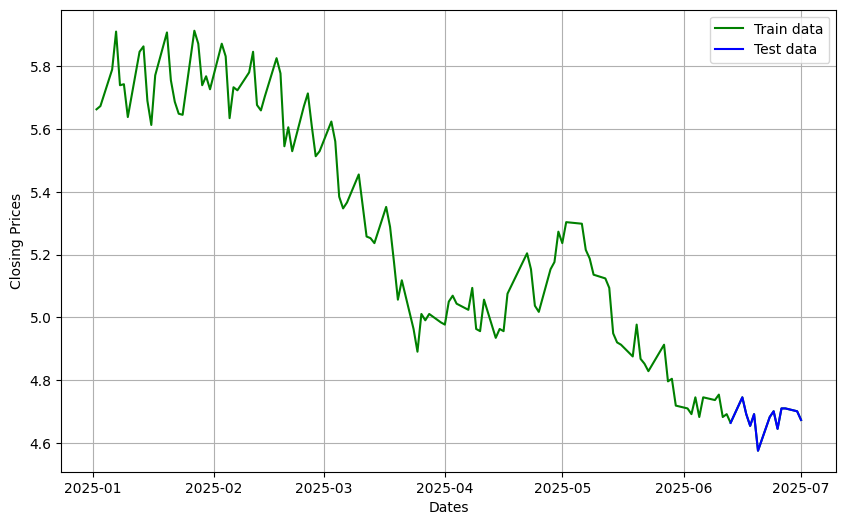

In [46]:
print(df_log.index)
train_data,test_data=train_test_split(df_log, 0.9)

In [47]:
train_data

Date
2025-01-02    5.662960
2025-01-03    5.673323
2025-01-06    5.789960
2025-01-07    5.910797
2025-01-08    5.739793
                ...   
2025-06-06    4.744932
2025-06-09    4.736198
2025-06-10    4.753590
2025-06-11    4.682131
2025-06-12    4.691348
Name: Closing price, Length: 112, dtype: float64

In [48]:
test_data

Date
2025-06-13    4.663439
2025-06-16    4.744932
2025-06-17    4.691348
2025-06-18    4.653960
2025-06-19    4.691348
2025-06-20    4.574711
2025-06-23    4.682131
2025-06-24    4.700480
2025-06-25    4.644391
2025-06-26    4.709530
2025-06-27    4.709530
2025-06-30    4.700480
2025-07-01    4.672829
Name: Closing price, dtype: float64

Model Selection

C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA par

AIC for ARIMA(1,1,1):-214.85473834844024
AIC for ARIMA(1,1,2):-217.0789778212876
AIC for ARIMA(1,1,3):-220.12897129362216
AIC for ARIMA(1,1,4):-219.70991683627838
AIC for ARIMA(1,1,5):-223.66099768161916
AIC for ARIMA(2,1,1):-220.88934923699924
AIC for ARIMA(2,1,2):-237.2028681158342
AIC for ARIMA(2,1,3):-241.22665050179094
AIC for ARIMA(2,1,4):-239.97185379120745
AIC for ARIMA(2,1,5):-238.99096794479942
AIC for ARIMA(3,1,1):-223.24290928512627
AIC for ARIMA(3,1,2):-241.31898181572873
AIC for ARIMA(3,1,3):-239.22091805219387
AIC for ARIMA(3,1,4):-237.49178815425668
AIC for ARIMA(3,1,5):-237.37759066455942
AIC for ARIMA(4,1,1):-225.5150080356675
AIC for ARIMA(4,1,2):-238.96523730093972
AIC for ARIMA(4,1,3):-239.45506314382823
AIC for ARIMA(4,1,4):-238.13694393012122
AIC for ARIMA(4,1,5):-235.942118102562
AIC for ARIMA(5,1,1):-236.5733882764709
AIC for ARIMA(5,1,2):-239.84365794013473
AIC for ARIMA(5,1,3):-238.0609544161327
AIC for ARIMA(5,1,4):-237.16032908770126
AIC for ARIMA(5,1,5):-2

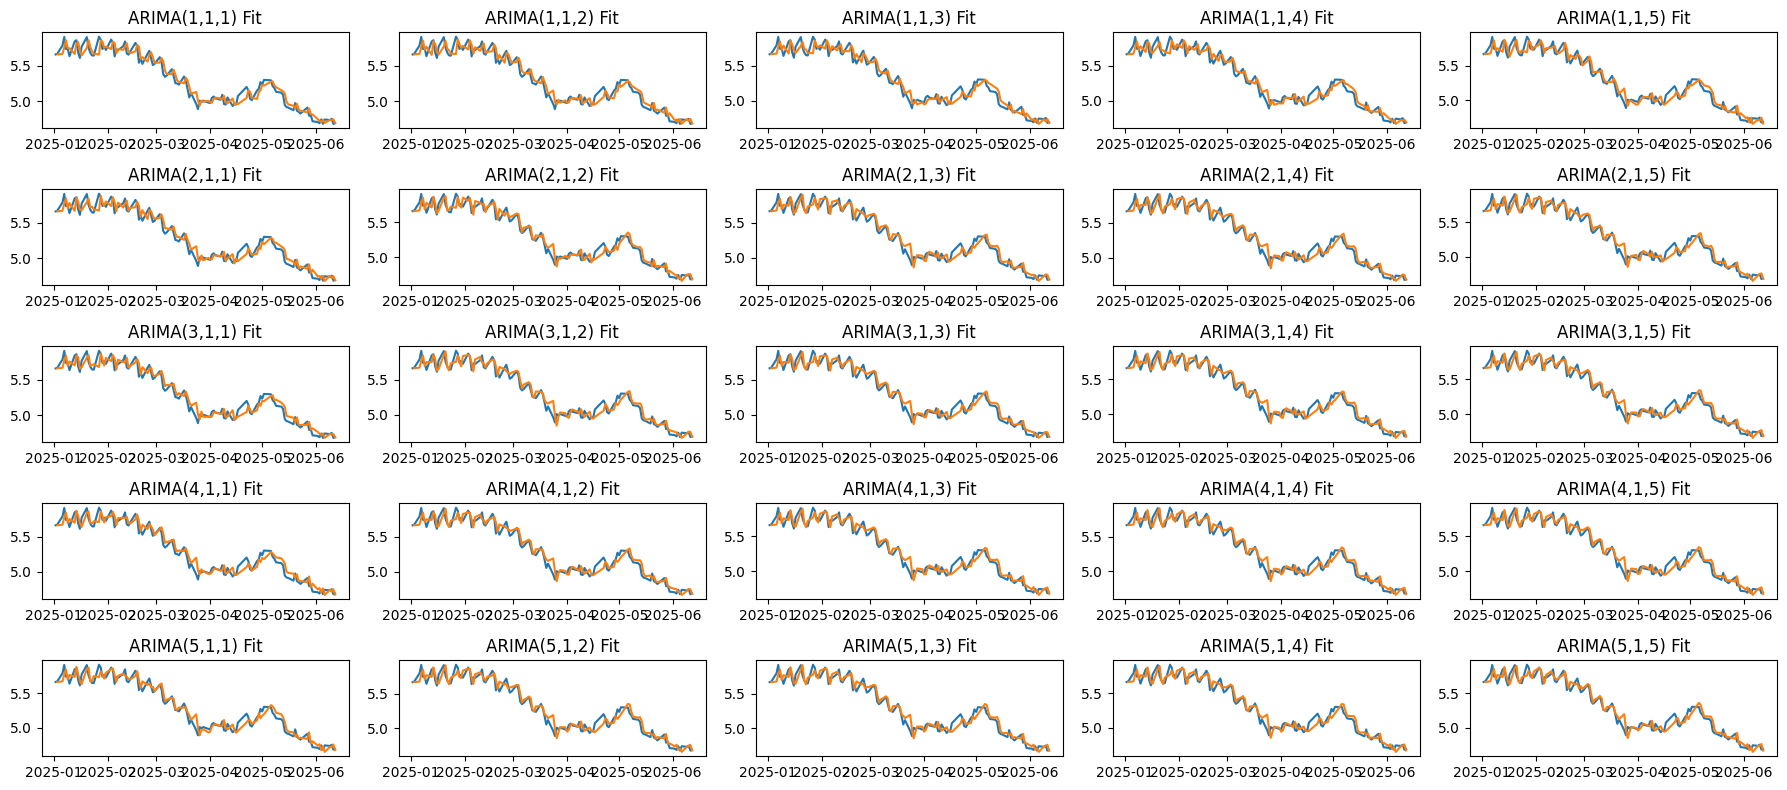

In [49]:
# model selection
ar_orders=[1,2,3,4,5]
ma_orders=[1,2,3,4,5]
fitted_model_dict={}
AIC_dict={}
fig,axes=plt.subplots(len(ar_orders),len(ma_orders),figsize=(18,8))
for idx, ar_order in enumerate(ar_orders):
    for idy, ma_order in enumerate(ma_orders):
        # create ARIMA model
        model=ARIMA(train_data, order=(ar_order,1,ma_order))
        model_fit = model.fit()
        fitted_model_dict[ar_order,ma_order]=model_fit
        AIC_dict[ar_order,ma_order]=fitted_model_dict[ar_order,ma_order].aic
        ax = axes[idx, idy]
        ax.set_title('ARIMA(%s,1,%s) Fit'%(ar_order,ma_order))
        ax.plot(train_data)
        ax.plot(model_fit.fittedvalues[1:])
plt.tight_layout()
for ar_order in ar_orders:
    for ma_order in ma_orders:
        print('AIC for ARIMA(%s,1,%s):%s'%(ar_order,ma_order,AIC_dict[ar_order,ma_order]))

In [50]:
# Sort the dictionary by value and return the first key-value pair
min_key, min_val = sorted(AIC_dict.items(), key=lambda x: x[1])[0]
print("The ARIMA model with the lowest AIC is: (%s,1,%s)"%(min_key[0],min_key[1]))

The ARIMA model with the lowest AIC is: (3,1,2)


Type Markdown and $$Latex:\alpha^{2}$$

Figure(1500x800)


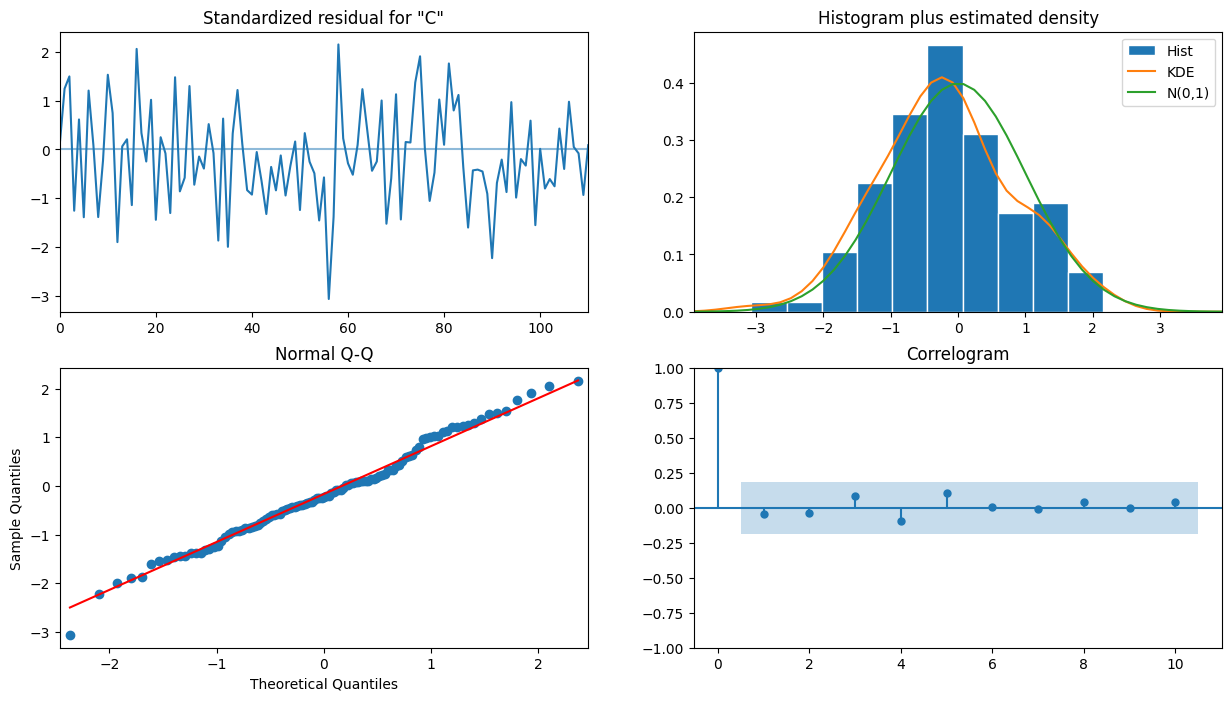

In [51]:
print(fitted_model_dict[min_key[0],min_key[1]].plot_diagnostics(figsize=(15,8)))

Test the data

Date
2025-01-02    5.662960
2025-01-03    5.673323
2025-01-06    5.789960
2025-01-07    5.910797
2025-01-08    5.739793
                ...   
2025-06-06    4.744932
2025-06-09    4.736198
2025-06-10    4.753590
2025-06-11    4.682131
2025-06-12    4.691348
Name: Closing price, Length: 112, dtype: float64
Date
2025-01-02    0.000000
2025-01-03    5.662960
2025-01-06    5.672521
2025-01-07    5.775465
2025-01-08    5.844472
                ...   
2025-06-06    4.669894
2025-06-09    4.732287
2025-06-10    4.759641
2025-06-11    4.753603
2025-06-12    4.684603
Length: 112, dtype: float64


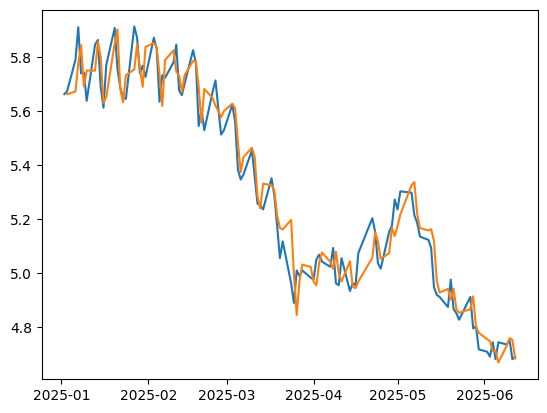

In [52]:
model_fit=fitted_model_dict[min_key[0],min_key[1]]
#model_fit=fitted_model_dict[3,2]
#get the predictions and residuals
predictions=model_fit.fittedvalues
# residuals = test_data - predictions
print(train_data)
print(predictions)
plt.plot(train_data)
plt.plot(predictions[1:])

In [53]:
pre_test=model_fit.forecast(steps=len(test_data))
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
print(pre_test)

112    4.685289
113    4.702313
114    4.709190
115    4.699132
116    4.685912
117    4.688389
118    4.702617
119    4.708352
120    4.697760
121    4.686122
122    4.689793
123    4.703230
124    4.707330
Name: predicted_mean, dtype: float64


C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [54]:
fc_series = pd.Series(np.array(pre_test), index=test_data.index)
fc_series

Date
2025-06-13    4.685289
2025-06-16    4.702313
2025-06-17    4.709190
2025-06-18    4.699132
2025-06-19    4.685912
2025-06-20    4.688389
2025-06-23    4.702617
2025-06-24    4.708352
2025-06-25    4.697760
2025-06-26    4.686122
2025-06-27    4.689793
2025-06-30    4.703230
2025-07-01    4.707330
dtype: float64

<Axes: xlabel='Date'>

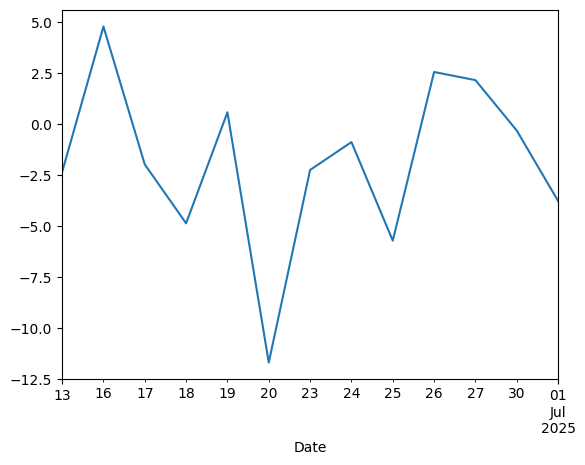

In [55]:
residuals=np.exp(test_data)-np.exp(fc_series)
residuals.plot()

RMSE: 4.440857261760172
MAPE: 0.032137819982394095
MSE: 19.72121321932805
MAE: 3.3711428479589065


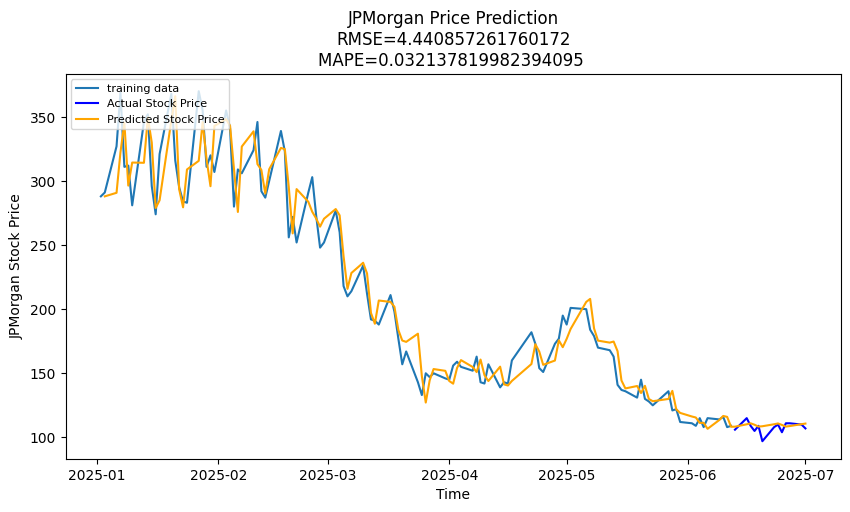

In [56]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
concat_df=[predictions[1:],fc_series]
pred_df=pd.concat(concat_df)
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(np.exp(pred_df), color = 'orange',label='Predicted Stock Price')
#plt.fillbetween(test_data.index, lower_series, upper_series, color='k', alpha=.15)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_series)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(residuals)/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))
mse = mean_squared_error(np.exp(test_data), np.exp(fc_series))
print('MSE: ' + str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc_series))
print('MAE: ' + str(mae))
plt.title('JPMorgan Price Prediction\nRMSE=%s\nMAPE=%s '%(str(rmse),str(mape)))
plt.xlabel('Time')
plt.ylabel('JPMorgan Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Using Auto-ARIMA Model

Rolling Forecasting Origin

In [57]:
# create the model 
from datetime import timedelta
predictions_rolling=pd.Series(dtype=float)
for end_date in test_data.index:
    train_data=df_log[:end_date-timedelta(days=1)]
    model=auto_arima(train_data, seasonal=False,stepwise=True,suppress_warnings=True,error_action='ignore',max_order=None,trace=False)
    pred = model.predict(n_periods=1)
    predictions_rolling.loc[end_date]=pred.values[0]
print(model.summary())

C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next vers

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  124
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 145.587
Date:                Tue, 12 Mar 2024   AIC                           -277.173
Time:                        18:34:32   BIC                           -257.488
Sample:                             0   HQIC                          -269.177
                                - 124                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0122      0.006     -2.116      0.034      -0.024      -0.001
ar.L1          0.5641      0.024     23.933      0.000       0.518       0.610
ar.L2         -0.9825      0.015    -64.014      0.0

C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


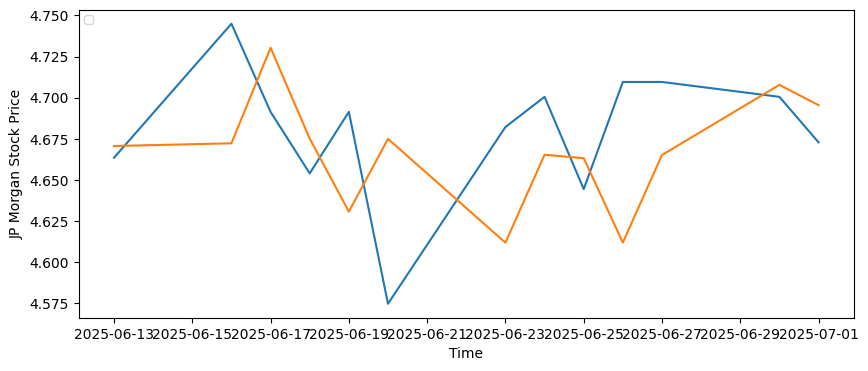

In [58]:
# draw the prediction plot
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions_rolling)

plt.xlabel('Time')
plt.ylabel('JP Morgan Stock Price')
plt.legend(loc='upper left', fontsize=8)

In [59]:
residuals_rolling=np.exp(test_data)-np.exp(predictions_rolling) # get the residuals
print(residuals_rolling)
print(predictions_rolling)

Date
2025-06-13    -0.762148
2025-06-16     8.063808
2025-06-17    -4.331274
2025-06-18    -2.240515
2025-06-19     6.413298
2025-06-20   -10.225960
2025-06-23     7.329173
2025-06-24     3.806163
2025-06-25    -1.973501
2025-06-26    10.326316
2025-06-27     4.820744
2025-06-30    -0.803425
2025-07-01    -2.447973
dtype: float64
2025-06-13    4.670603
2025-06-16    4.672232
2025-06-17    4.730315
2025-06-18    4.675074
2025-06-19    4.630708
2025-06-20    4.674938
2025-06-23    4.611856
2025-06-24    4.665266
2025-06-25    4.663189
2025-06-26    4.611884
2025-06-27    4.665129
2025-06-30    4.707758
2025-07-01    4.695449
dtype: float64


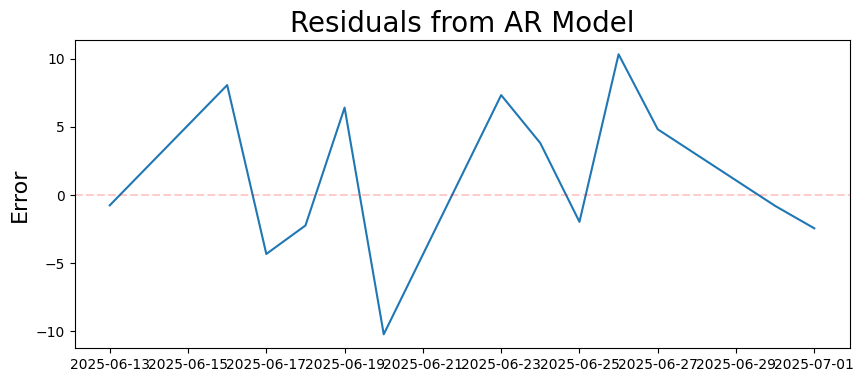

In [60]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)

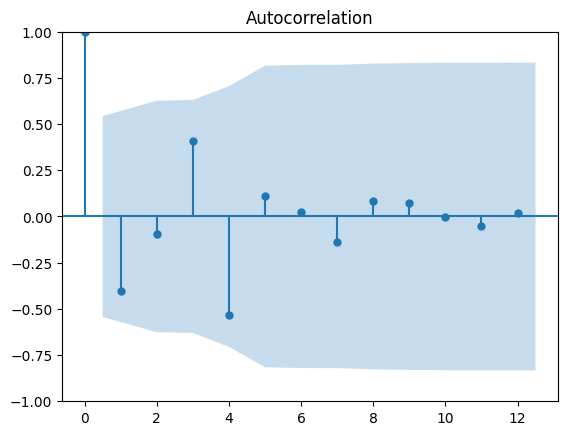

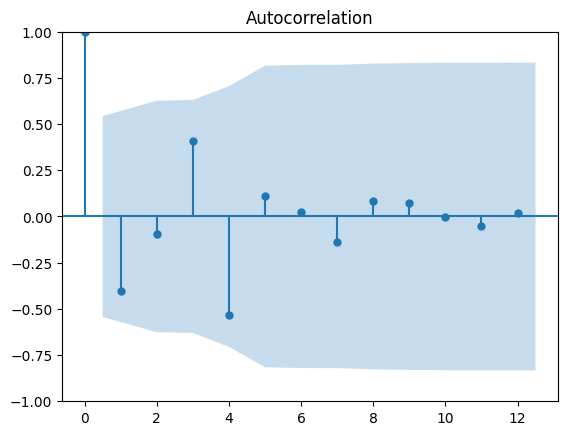

In [61]:
plot_acf(residuals_rolling,lags=12)

In [62]:
print('Mean Absolute Percent Error:',round(np.mean(abs(residuals_rolling/np.exp(test_data))),4))
print('Root Mean Squared Error:',np.sqrt(np.mean(residuals_rolling**2)))

Mean Absolute Percent Error: 0.0454
Root Mean Squared Error: 5.842122591392445


RMSE: 5.842122591392445
MAPE: 0.04544053804565078
MSE: 34.13039637285798
MAE: 4.888022978188989


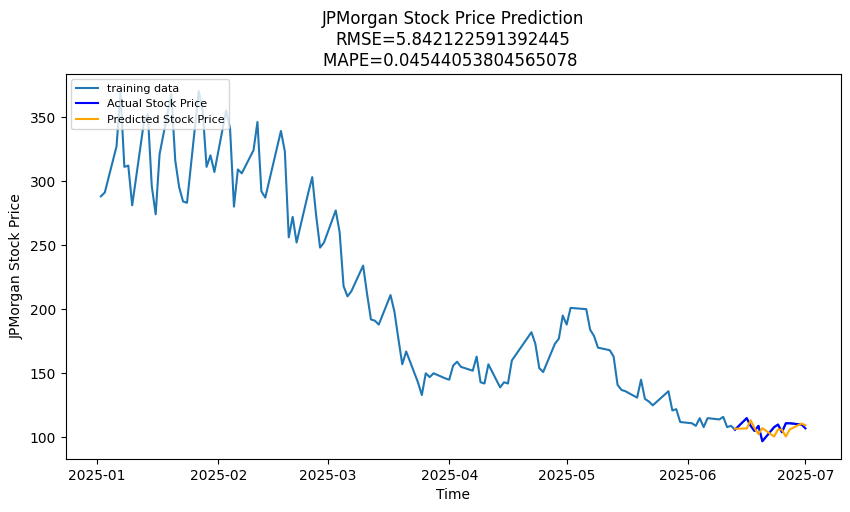

In [63]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(np.exp(predictions_rolling), color = 'orange',label='Predicted Stock Price')
#plt.fillbetween(test_data.index, lower_series, upper_series, color='k', alpha=.15)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(predictions_rolling)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(residuals_rolling)/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))
mse = mean_squared_error(np.exp(test_data), np.exp(predictions_rolling))
print('MSE: ' + str(mse))
# 平均绝对误差（MAE）
mae = mean_absolute_error(np.exp(test_data), np.exp(predictions_rolling))
print('MAE: ' + str(mae))
plt.title('JPMorgan Stock Price Prediction\nRMSE=%s\nMAPE=%s '%(str(rmse),str(mape)))
plt.xlabel('Time')
plt.ylabel('JPMorgan Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()